# Прогноз страховых расходов + Статистический анализ

---

## Цель проекта

Провести исследование факторов, влияющих на стоимость медицинской страховки, и спрогнозировать расходы клиентов страховой компании с помощью моделей машинного обучения.

В рамках проекта будет:
- Проведён исследовательский анализ данных (EDA).
- Сформулирована и проверена статистическая гипотеза.
- Построено несколько моделей прогнозирования расходов.
- Выбрана и оптимизирована лучшая модель.
- Сделаны выводы.

---

## Формулировка гипотезы

**Нулевая гипотеза (H₀):**  
_У людей одной возрастной группы цена страховки не зависит от факта курения._

**Альтернативная гипотеза (H₁):**  
_Цена страховки у курящих людей в одной возрастной группе будет существенно выше, чем у некурящих._

Проверка гипотезы позволит определить влияние курения на стоимость медицинской страховки.

Значение p-value устанавливаем 0,05

---

## План проекта

1. Загрузка и первичная проверка данных.
2. Анализ данных (EDA).
3. Категоризация индекса массы тела (BMI) по американским стандартам.
4. Проверка статистической гипотезы.
5. Подготовка данных для ML.
6. Проверка мультиколлинеарности признаков (VIF)
7. Построение и сравнение моделей.
8. Оптимизация лучшей модели.
9. Финальные выводы и рекомендации.

---

## Описание данных

Набор данных `insurance.csv` содержит 1338 записей и 7 признаков:

- **age** — возраст клиента;
- **sex** — пол клиента;
- **bmi** — индекс массы тела;
- **children** — количество детей;
- **smoker** — курит ли клиент (yes / no);
- **region** — регион проживания (southeast, southwest, northeast, northwest);
- **expenses** — медицинские расходы (целевая переменная).

> **Примечание:**  
> Для анализа признака BMI используется классификация по стандартам США:
> - Нормальный вес: 18.5–24.9
> - Избыточная масса тела: 25–29.9
> - Ожирение I степени: 30–34.9
> - Ожирение II степени: 35–39.9
> - Ожирение III степени: ≥40

---


# 1. Загрузка библиотек и данных

На этом этапе:
- Импортируем все необходимые библиотеки.
- Определим вспомогательные функции.
- Загрузим датасет для дальнейшей работы.


In [172]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import randint, mannwhitneyu

from colorama import Fore, Back, Style
warnings.filterwarnings('ignore')

#  Функция для комплексной оценки качества модели
def evaluate_preds(train_true, train_pred, test_true, test_pred):
    print(f"Train R²:\t{r2_score(train_true, train_pred):.3f}")
    print(f"Test R²:\t{r2_score(test_true, test_pred):.3f}")
    print(f"Test MAE:\t{mean_absolute_error(test_true, test_pred):.2f}")
    print(f"Test RMSE:\t{mean_squared_error(test_true, test_pred, squared=False):.2f}")
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=train_pred, y=train_true)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=test_pred, y=test_true)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    
    plt.tight_layout()
    plt.show()

# Функция для подсветки лучших метрик
def highlight_best(s, better='higher'):
    """
    Подсвечивает лучшие значения:
    - если better = 'higher', подсвечивается максимальное значение (зелёным)
    - если better = 'lower', подсвечивается минимальное значение (зелёным)
    """
    is_numeric = pd.to_numeric(s, errors='coerce').notnull()
    if better == 'higher':
        return ['background-color: lightgreen' if v == s.max() else '' for v in s]
    else:
        return ['background-color: lightgreen' if v == s.min() else '' for v in s]


#  Функция для оценки модели с помощью кросс-валидации
def cross_val(X_train, y_train, model):
    scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, scoring='r2')
    return scores.mean()

#  Загрузка данных
df = pd.read_csv('insurance.csv')

#  Размер таблицы
print(f"Размер таблицы: {df.shape}")

#  Просмотр первых строк
df.head()


Размер таблицы: (1338, 7)


,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


# 2. Анализ данных (EDA)

На этом этапе:

- Проверим наличие пропусков и типы данных.
- Изучим основные описательные статистики.
- Построим распределения ключевых признаков.
- Оценим взаимосвязи между признаками.

Цель: убедиться в корректности данных и выявить предварительные зависимости для дальнейшего анализа.

### 2.1 Базовая проверка данных:

In [108]:
# Проверка наличия пропущенных значений
print("Количество пропущенных значений в каждом столбце:\n")
print(df.isnull().sum())

# Проверка типов данных
print("\nТипы данных:")
print(df.dtypes)

# Основные статистики
df.describe()


Количество пропущенных значений в каждом столбце:

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

Типы данных:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
expenses    float64
dtype: object


,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


### Базовая проверка данных показала что:

- Пропущенных значений в данных нет, что позволяет сразу перейти к дальнейшему анализу без необходимости обработки пропусков.
- Типы данных корректные: числовые признаки представлены числами (`int64`, `float64`), категориальные — объектами (`object`).
- Минимальные, максимальные значения и стандартные отклонения выглядят реалистично.
- Расходы на медицинскую страховку варьируются от ~1100 до ~63 770 долларов, что отражает широкий разброс стоимости страховки в зависимости от характеристик клиентов.
- Индекс массы тела (BMI) в выборке варьируется от 16 до 53, что охватывает как нормальный вес, так и ожирение высокой степени.


### 2.2 Визуальный анализ признаков

На этом этапе мы визуально исследуем распределения основных признаков, чтобы:

- Оценить форму распределений (нормальность, скошенность).
- Выявить возможные выбросы и аномалии.
- Проверить взаимосвязи между признаками и целевой переменной (расходами на страховку).

Начнём с анализа распределений числовых признаков.


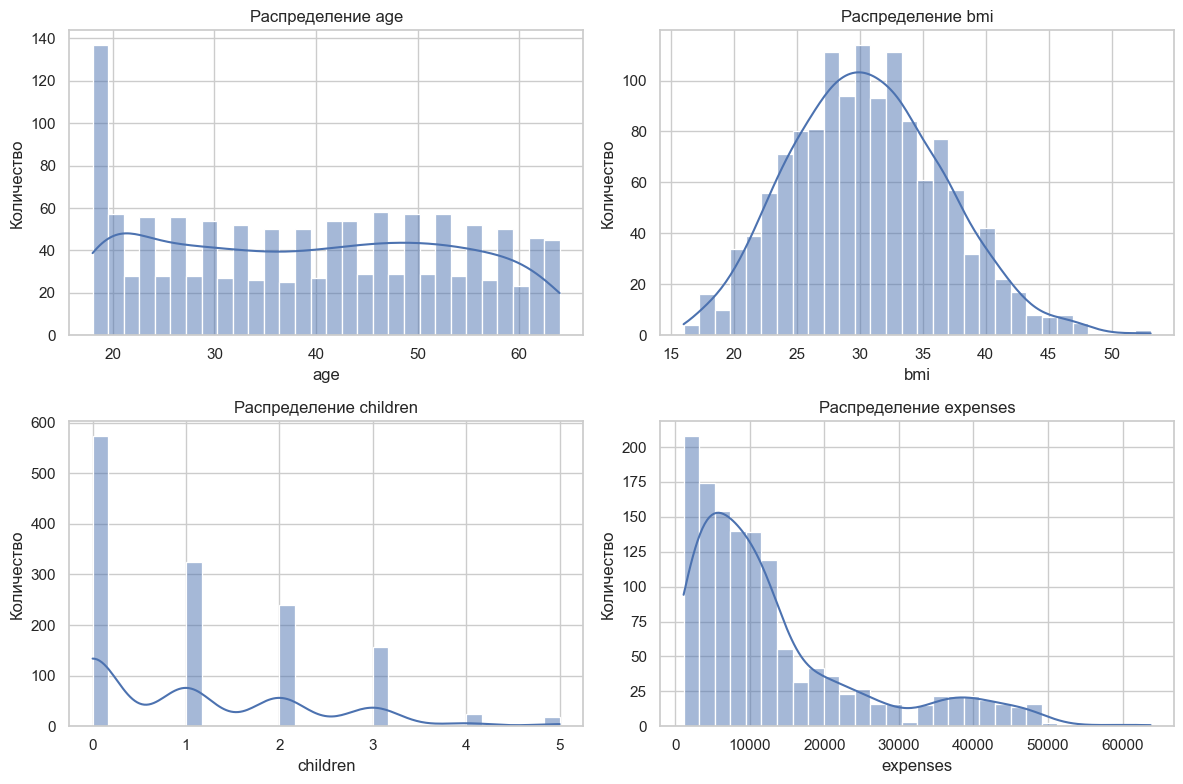

In [112]:
# Визуализация распределений числовых признаков

num_features = ['age', 'bmi', 'children', 'expenses']

plt.figure(figsize=(12, 8))

for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=feature, kde=True, bins=30)
    plt.title(f'Распределение {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество')

plt.tight_layout()
plt.show()



### Выводы по распределению числовых признаков

- **Возраст (`age`)**:  
  Распределение близко к равномерному с лёгким смещением в сторону более молодых клиентов. Основная масса клиентов находится в возрасте от 20 до 50 лет.

- **Индекс массы тела (`bmi`)**:  
  Распределение похоже на нормальное, но с небольшим смещением вправо (в сторону больших значений). Видны клиенты с очень высоким BMI, что может указывать на ожирение.

- **Количество детей (`children`)**:  
  Большинство клиентов имеют 0–2 детей. Число клиентов с 4–5 детьми значительно ниже.

- **Расходы на страховку (`expenses`)**:  
  Распределение сильно скошено. Основная масса расходов лежит в диапазоне до 20 000, но есть клиенты с экстремально высокими расходами до 60 000+, что создаёт длинный хвост.

---

В целом данные выглядят адекватно. Однако при построении моделей стоит учитывать скошенность целевой переменной (`expenses`) и наличие экстремальных значений.

### Анализ распределения категориальных признаков

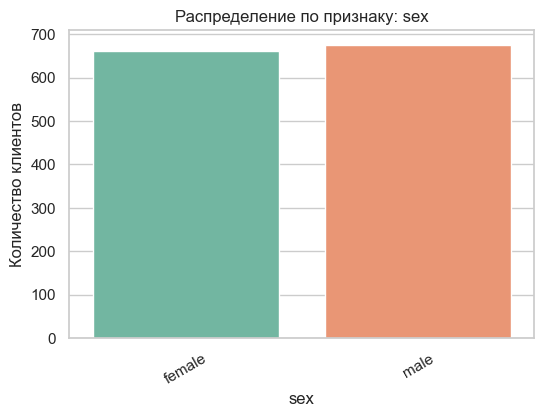

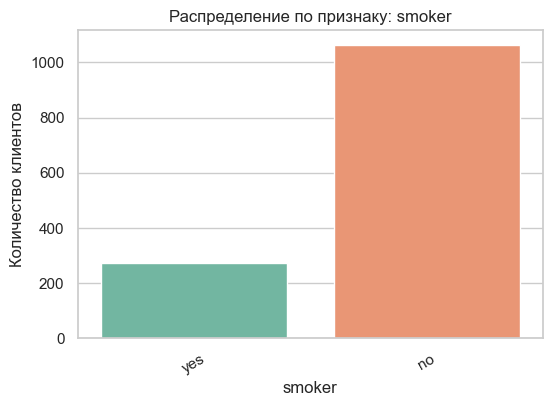

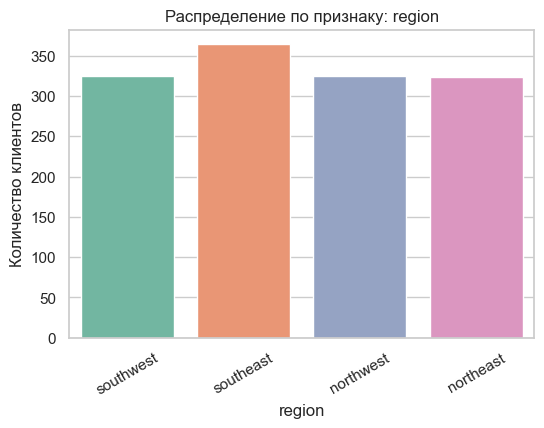

In [115]:
categorical_features = ['sex', 'smoker', 'region']

for feature in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=feature, palette="Set2")
    plt.title(f'Распределение по признаку: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество клиентов')
    plt.xticks(rotation=30)
    plt.show()


### Анализ категориальных признаков показал, что:

- Распределение по полу клиентов практически равномерное, с небольшим преобладанием мужчин.
- Доля курящих клиентов значительно меньше, чем некурящих, что может повлиять на дальнейший анализ факторов риска.
- Распределение по регионам примерно равномерное, без ярко выраженного перекоса в какую-либо сторону.

Распределения категориальных признаков выглядят адекватными, и признаков с критическим дисбалансом нет. Это позволяет использовать их в дальнейшем анализе без дополнительной обработки.

### Теперь проведем проверку выбросов в данных.

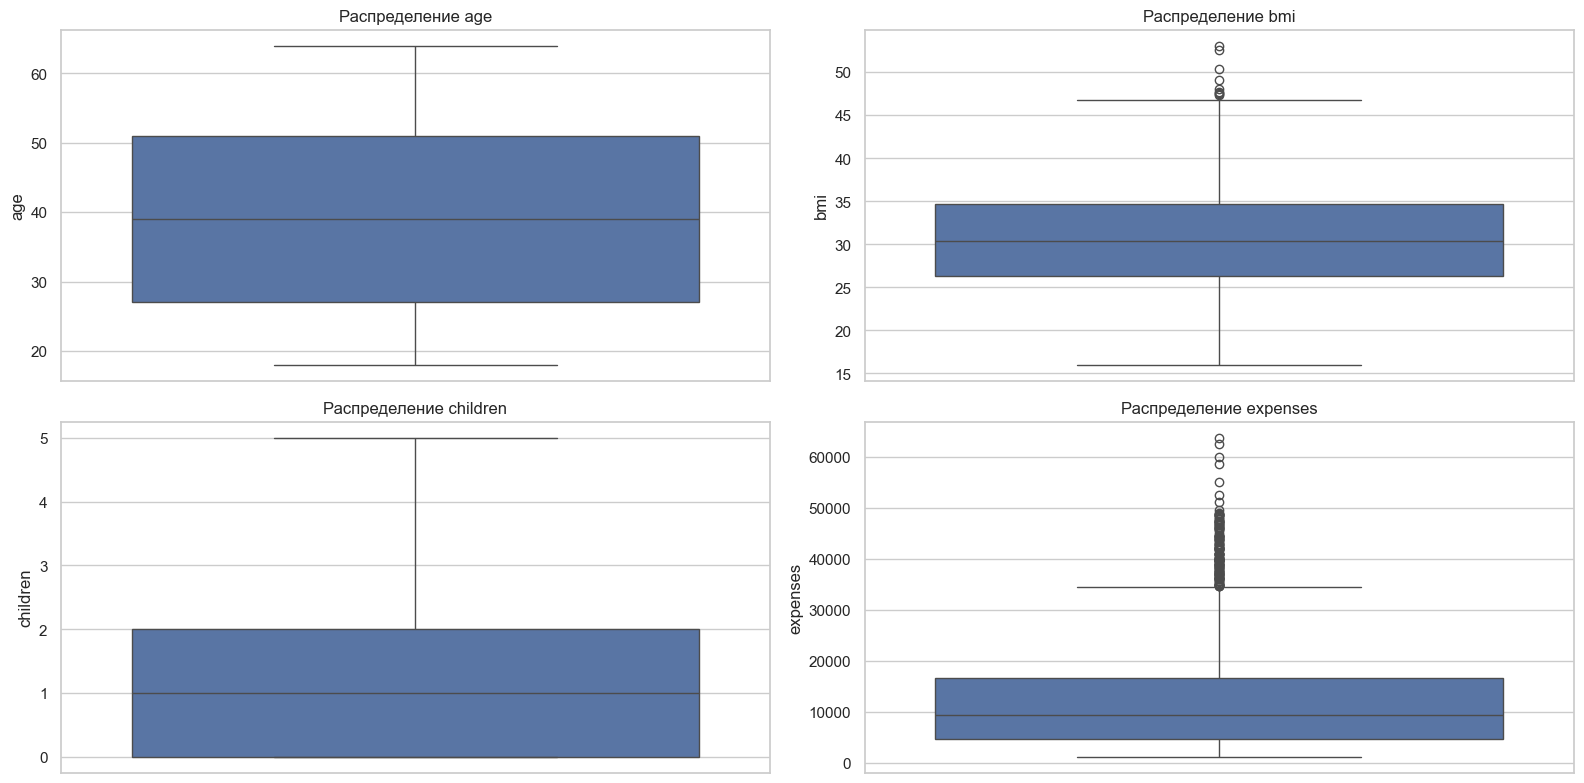

In [118]:
# Boxplot для поиска выбросов в числовых признаках
num_features = ['age', 'bmi', 'children', 'expenses']

plt.figure(figsize=(16, 8))

for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[feature])
    plt.title(f'Распределение {feature}')

plt.tight_layout()
plt.show()


### Вывод по выбросам

- В признаках `age` и `children` выбросов почти нет.
- В `bmi` есть несколько высоких значений, что мы и предпологали на этапе визуальной оцунки числовых признаков, и конечно это характерно для очень высокого индекса массы тела.
- В целевой переменной `expenses` наблюдаются высокие значения (очень дорогие страховки), что, тоже, логично — тяжёлые случаи страхуются дороже.
- Удалять выбросы не будем, так как они отражают реальную картину расходов.

### Теперь переходим к проверке взаимосвязи признаков с расходами

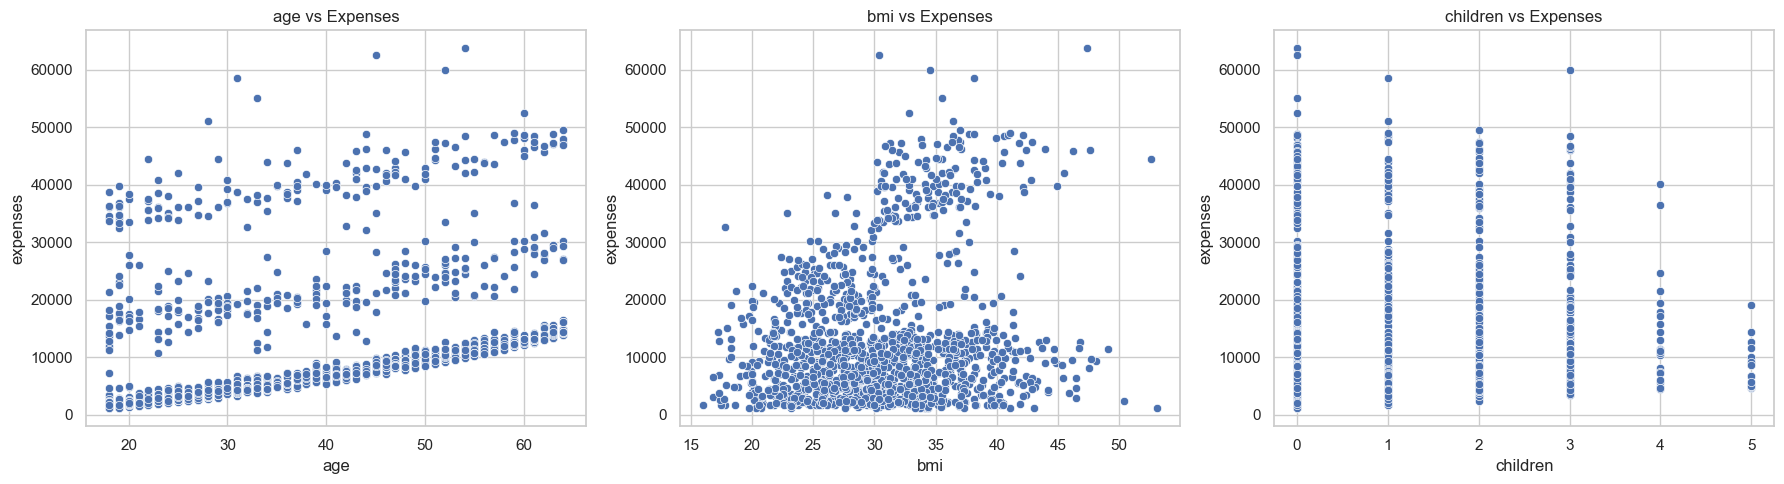

In [122]:
# Scatterplots для числовых признаков
num_features = ['age', 'bmi', 'children']

plt.figure(figsize=(18, 5))

for i, feature in enumerate(num_features, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=df[feature], y=df['expenses'])
    plt.title(f'{feature} vs Expenses')

plt.tight_layout()
plt.show()


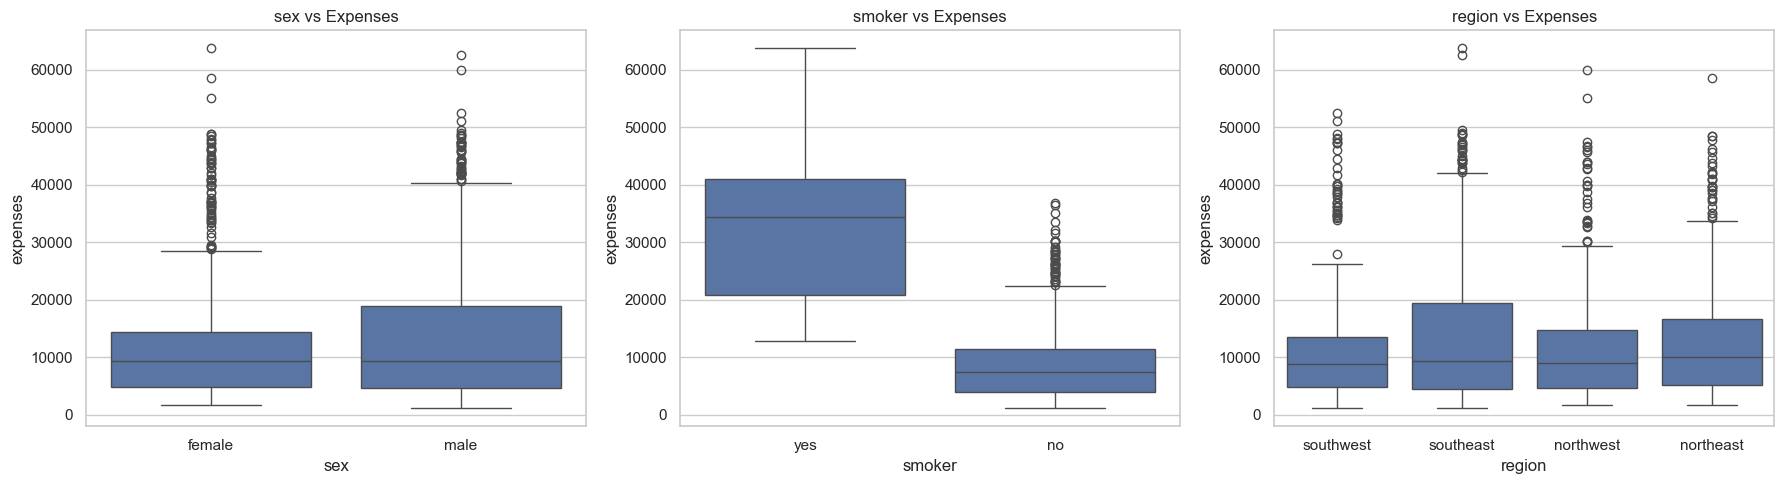

In [125]:
# Boxplots для категориальных признаков
cat_features = ['sex', 'smoker', 'region']

plt.figure(figsize=(18, 5))

for i, feature in enumerate(cat_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df[feature], y=df['expenses'])
    plt.title(f'{feature} vs Expenses')

plt.tight_layout()
plt.show()


### Вывод по взаимосвязям признаков с расходами

- Расходы на страховку растут с возрастом клиента.
- Более высокий индекс массы тела (BMI) в целом связан с увеличением расходов.
- Наличие детей на расходы влияет слабо.
- Курящие клиенты платят заметно больше за страховку, что видно из boxplot'ов.
- Пол (sex) и регион проживания (region) влияют на расходы гораздо слабее.

### Переходим к проверки нормальности распределения нашего целевого признака - расходов (expenses)

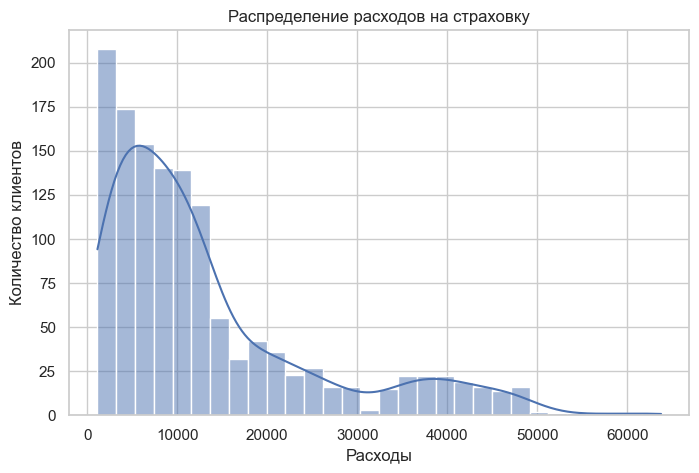

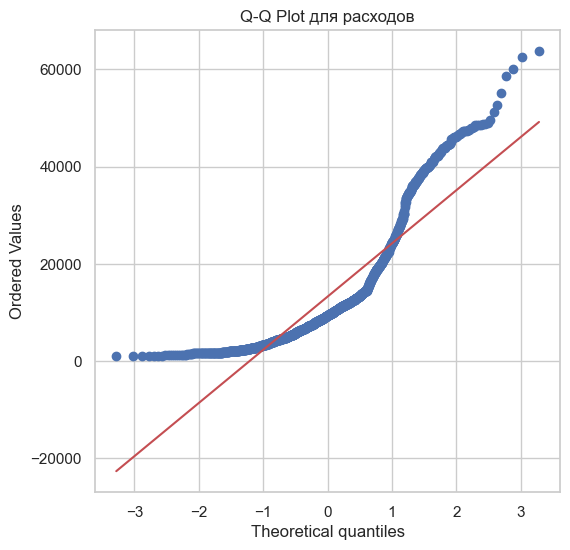

In [129]:
# Проверка нормальности целевой переменной
plt.figure(figsize=(8, 5))
sns.histplot(df['expenses'], kde=True, bins=30)
plt.title('Распределение расходов на страховку')
plt.xlabel('Расходы')
plt.ylabel('Количество клиентов')
plt.show()

# Q-Q plot
import scipy.stats as stats

plt.figure(figsize=(6, 6))
stats.probplot(df['expenses'], dist="norm", plot=plt)
plt.title('Q-Q Plot для расходов')
plt.show()


### Вывод по "нормальности" расходов

- Распределение расходов на страховку не является нормальным: оно сильно скошено вправо.
- Присутствуют клиенты с очень высокими страховыми расходами.
- При построении моделей и проверке статистических гипотез это необходимо учитывать, так как от распределения зависит выбор статистического теста.
- В дополнение к визуальному анализу нормальность можно было бы проверить с помощью теста Шапиро–Уилка. Однако в нашем случае это не требуется, поскольку визуальные показатели распределения дают однозначный результат.
---
### Касаемо выбросов

В данных наблюдаются клиенты с очень высокими страховыми расходами (правый хвост распределения). Это характерная особенность страховых выплат, где небольшая доля клиентов может иметь экстремальные значения расходов (например, из-за тяжёлых заболеваний). 

**Удаление выбросов не требуется**, так как они отражают реальную природу страховых данных и важны для построения корректной модели.


## Финальный вывод по блоку 2

- Все числовые признаки в данных адекватны и не содержат пропущенных значений.
- Распределения признаков разумные: возраст и индекс массы тела (BMI) варьируются в пределах ожидаемых значений.
- Расходы на медицинскую страховку имеют скошенное вправо распределение с выбросами, что важно учитывать в дальнейшем анализе.
- Исследование взаимосвязей показало:
  - Расходы на страховку растут с возрастом клиента.
  - Более высокий индекс массы тела (BMI) в целом связан с увеличением расходов.
  - Наличие детей влияет на расходы слабо.
  - Курение значительно увеличивает стоимость страховки.
  - Пол и регион проживания влияют на расходы минимально.
- Выбросов, требующих удаления на этом этапе, не выявлено.

На основании проведенного анализа можно переходить к следующему этапу.


# 3. Категоризация индекса массы тела (BMI)

На этом этапе мы расширим наши данные, введя новый категориальный признак на основе показателя BMI.

Для категоризации будем использовать классификацию по стандартам США:

- **Нормальный вес:** 18.5–24.9
- **Избыточная масса тела:** 25–29.9
- **Ожирение I степени:** 30–34.9
- **Ожирение II степени:** 35–39.9
- **Ожирение III степени:** ≥ 40

Создание нового признака поможет лучше учесть влияние веса на стоимость страховки при дальнейшем анализе и построении моделей.


In [135]:
# Функция для категоризации по стандартам США
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    elif 30 <= bmi < 35:
        return 'Obesity I'
    elif 35 <= bmi < 40:
        return 'Obesity II'
    else:
        return 'Obesity III'

# Применяем функцию к столбцу BMI
df['bmi_category'] = df['bmi'].apply(bmi_category)

# Проверяем результат
df[['bmi', 'bmi_category']].head(10)


,bmi,bmi_category
0,27.9,Overweight
1,33.8,Obesity I
2,33.0,Obesity I
3,22.7,Normal
4,28.9,Overweight
5,25.7,Overweight
6,33.4,Obesity I
7,27.7,Overweight
8,29.8,Overweight
9,25.8,Overweight


### Проверим, как выглядит датафрейм после добавления нового признака

In [138]:
df.head(10)

,age,sex,bmi,children,smoker,region,expenses,bmi_category
0,19,female,27.9,0,yes,southwest,16884.92,Overweight
1,18,male,33.8,1,no,southeast,1725.55,Obesity I
2,28,male,33.0,3,no,southeast,4449.46,Obesity I
3,33,male,22.7,0,no,northwest,21984.47,Normal
4,32,male,28.9,0,no,northwest,3866.86,Overweight
5,31,female,25.7,0,no,southeast,3756.62,Overweight
6,46,female,33.4,1,no,southeast,8240.59,Obesity I
7,37,female,27.7,3,no,northwest,7281.51,Overweight
8,37,male,29.8,2,no,northeast,6406.41,Overweight
9,60,female,25.8,0,no,northwest,28923.14,Overweight


### 3. Итоги категоризации BMI

На этом этапе:

- Мы классифицировали индекс массы тела (BMI) клиентов в соответствии со стандартами США.
- Добавили в данные новый категориальный признак `bmi_category`.
- Теперь в дальнейшем анализе и построении моделей мы сможем использовать как числовой показатель BMI, так и его категориальное представление для более гибкой работы с данными.


# 4. Проверка статистической гипотезы

На этом этапе мы проверим сформулированную ранее гипотезу о влиянии курения на стоимость медицинской страховки.

**Гипотезы:**

- **Нулевая гипотеза (H₀):** У людей одной возрастной группы цена страховки не зависит от факта курения.
- **Альтернативная гипотеза (H₁):** Цена страховки у курящих людей в одной возрастной группе существенно выше.

Проверка будет включать:
- Разделение клиентов на группы по возрасту.
- Визуальный анализ различий в стоимости страховки между курящими и некурящими.
- Формальную проверку статистических различий с помощью теста.


### 4.1 Создадим возрастные группы
Для более корректного сравнения разобьем клиентов на группы по возрасту (по 10 лет).

In [143]:
# Создадим возрастные группы
bins = [17, 25, 35, 45, 55, 65]
labels = ['18–25', '26–35', '36–45', '46–55', '56–65']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

# Проверим
df.head(10)

,age,sex,bmi,children,smoker,region,expenses,bmi_category,age_group
0,19,female,27.9,0,yes,southwest,16884.92,Overweight,18–25
1,18,male,33.8,1,no,southeast,1725.55,Obesity I,18–25
2,28,male,33.0,3,no,southeast,4449.46,Obesity I,26–35
3,33,male,22.7,0,no,northwest,21984.47,Normal,26–35
4,32,male,28.9,0,no,northwest,3866.86,Overweight,26–35
5,31,female,25.7,0,no,southeast,3756.62,Overweight,26–35
6,46,female,33.4,1,no,southeast,8240.59,Obesity I,46–55
7,37,female,27.7,3,no,northwest,7281.51,Overweight,36–45
8,37,male,29.8,2,no,northeast,6406.41,Overweight,36–45
9,60,female,25.8,0,no,northwest,28923.14,Overweight,56–65


### 4.2  Визуализируем различия расходов в зависимости от факта курения внутри возрастных групп

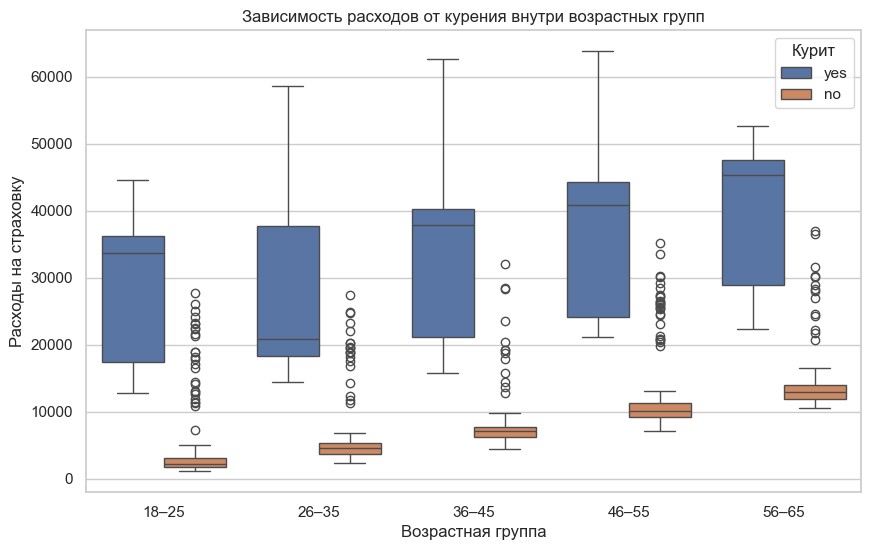

In [146]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='age_group', y='expenses', hue='smoker', data=df)
plt.title('Зависимость расходов от курения внутри возрастных групп')
plt.xlabel('Возрастная группа')
plt.ylabel('Расходы на страховку')
plt.legend(title='Курит')
plt.show()

### 4.3 Выбор и проведение статистического теста

На предыдущем этапе мы увидели визуальные различия в страховых расходах между курящими и некурящими клиентами.

Теперь выберем подходящий тест для формальной проверки гипотезы:

- Переменная курения (`smoker`) — категориальная, имеет две группы (да/нет).
- Расходы (`expenses`) — количественная переменная.
- Распределение расходов не является нормальным (ранее выявленная скошенность).

**Итог:**  
Для сравнения двух независимых выборок с ненормальным распределением мы будем использовать **непараметрический тест Манна–Уитни (Mann–Whitney U-test)**.


In [149]:
# Делим данные на две группы
smoker_expenses = df[df['smoker'] == 'yes']['expenses']
nonsmoker_expenses = df[df['smoker'] == 'no']['expenses']

# Проводим тест Манна–Уитни
stat, p = mannwhitneyu(smoker_expenses, nonsmoker_expenses, alternative='greater')

print(f"Статистика U-теста: {stat:.2f}")
print(f"p-value: {p:.5f}")

Статистика U-теста: 284133.00
p-value: 0.00000


### Вывод по проверке гипотезы

На основе проведённого теста Манна–Уитни:

- **Статистика U-теста:** 284133.00
- **p-value:** < 0.00001

**Интерпретация результата:**

Поскольку p-value значительно меньше стандартного уровня значимости 0.05, мы **отвергаем нулевую гипотезу**.

**Итог:**  
Расходы на медицинскую страховку **существенно выше** у курящих клиентов по сравнению с некурящими **в рамках одной возрастной группы**.

Фактор курения оказывает **значимое влияние** на стоимость страховки, что согласуется с бизнес-логикой: курение увеличивает риски для здоровья, а значит и расходы страховой компании.


# 5. Подготовка данных для дальнейшего ML

На этом этапе мы подготовим данные для обучения моделей машинного обучения.

Делаем:

- Кодирование категориальных признаков в числовой формат (One-Hot Encoding).
- Масштабирование числовых признаков.
- Разделение данных на обучающую и тестовую выборки.


In [153]:
# Выделяем числовые и категориальные признаки
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region', 'bmi_category', 'age_group']

# Целевая переменная
target = 'expenses'

# Разделяем признаки и целевую переменную
X = df[numeric_features + categorical_features]
y = df[target]

# One-Hot Encoding для категориальных признаков
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Масштабирование числовых признаков
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Проверим размерности
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Размер обучающей выборки: (1070, 17)
Размер тестовой выборки: (268, 17)


### Итоги подготовки данных

- Категориальные признаки были преобразованы с помощью One-Hot Encoding.
- Числовые признаки (`age`, `bmi`, `children`) масштабированы с помощью стандартизации.
- Данные разделены на обучающую (80%) и тестовую (20%) выборки.

Теперь данные готовы к дальнейшему ML.


# 6. Проверка мультиколлинеарности признаков (VIF)

На этом этапе мы проверим данные на наличие мультиколлинеарности между признаками с помощью расчёта коэффициента инфляции дисперсии (VIF).

> **Что такое мультиколлинеарность?**  
> Мультиколлинеарность — это ситуация, когда два или более признаков сильно коррелируют между собой. Это может привести к нестабильности модели, особенно в случае линейной регрессии.

> **Зачем проверять мультиколлинеарность?**  
> - При сильной мультиколлинеарности оценки коэффициентов становятся ненадежными.
> - Модель может переобучаться или давать некорректные предсказания.
> - Важно на этапе подготовки данных выявить такие признаки и при необходимости устранить.

**Как будем проверять:**  
Рассчитаем VIF для всех признаков обучающей выборки.  
Если VIF какого-либо признака существенно превышает 5–10, это сигнал о наличии мультиколлинеарности.

---


In [192]:
# Приводим все признаки к типу float
X_train_vif = X_train.astype(float)

# Расчёт VIF
vif_data = pd.DataFrame()
vif_data["Признак"] = X_train_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]

# Вывод
vif_data.sort_values(by="VIF", ascending=False)



,Признак,VIF
16,age_group_56–65,15.383274
0,age,12.234894
15,age_group_46–55,12.188404
9,bmi_category_Obesity II,10.312650
1,bmi,9.889630
8,bmi_category_Obesity I,8.759594
10,bmi_category_Obesity III,8.017098
14,age_group_36–45,5.835337
11,bmi_category_Overweight,3.982641
13,age_group_26–35,2.468349


### Вывод по проверке мультиколлинеарности (VIF)

- Некоторые признаки показывают высокий уровень мультиколлинеарности:
  - `age` и возрастные группы (`age_group_56–65`, `age_group_46–55`, `age_group_36–45`) имеют VIF выше 10, что указывает на сильную корреляцию между ними.
  - Категориальные признаки по BMI (`bmi_category_Obesity I`, `bmi_category_Obesity II`, `bmi_category_Obesity III`) также демонстрируют умеренную корреляцию с непрерывным признаком `bmi`.

- В реальной задаче для повышения устойчивости модели можно было бы:
  - Удалить один из сильно коррелирующих признаков (например, оставить только `age` или только возрастные группы).
  - Провести дополнительный отбор признаков или использовать регуляризацию.

- **В рамках текущего проекта** мы оставляем все признаки без изменений, поскольку:
  - Мультиколлинеарность не влияет на качество прогноза нелинейных моделей (например, градиентного бустинга).
  - Линейная модель не является моим фаворитом и ставку я делаю на градиентный бустинг.

> **Важно:** в случае использования интерпретируемых моделей (например, линейной регрессии для объяснения факторов) мультиколлинеарность обязательно должна учитываться.


# 7. Построение и сравнение моделей

На этом этапе мы:

- Построим базовую модель линейной регрессии.
- Построим более сложную модель на основе градиентного бустинга.
- Оценим качество моделей на тестовой выборке с помощью следующих метрик:
  - **R² (коэффициент детерминации):** показывает долю дисперсии целевой переменной, объясняемую моделью (чем ближе к 1, тем лучше).
  - **MAE (средняя абсолютная ошибка):** средняя ошибка предсказаний в тех же единицах, что и целевая переменная.
  - **RMSE (корень из средней квадратичной ошибки):** штрафует модель за большие ошибки сильнее, чем MAE, но она чувствительна к выбросам.

> **Почему именно эти метрики?**  
> Для задачи регрессии важно не только общее качество предсказаний (R²), но и понимание абсолютных ошибок модели (MAE, RMSE). Использование нескольких метрик даёт более полную картину качества моделей.

- Сравним результаты моделей и выберем лучшую, для дальнейшей работы с ней.

In [174]:
# Список для хранения результатов
model_results = []

# 1. Линейная регрессия
lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)

model_results.append({
    'Модель': 'Линейная регрессия',
    'Train R²': r2_score(y_train, y_train_pred_lr),
    'Test R²': r2_score(y_test, y_test_pred_lr),
    'Test MAE': mean_absolute_error(y_test, y_test_pred_lr),
    'Test RMSE': mean_squared_error(y_test, y_test_pred_lr, squared=False)
})

# 2. Градиентный бустинг
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_train_pred_gbr = gbr.predict(X_train)
y_test_pred_gbr = gbr.predict(X_test)

model_results.append({
    'Модель': 'Градиентный бустинг',
    'Train R²': r2_score(y_train, y_train_pred_gbr),
    'Test R²': r2_score(y_test, y_test_pred_gbr),
    'Test MAE': mean_absolute_error(y_test, y_test_pred_gbr),
    'Test RMSE': mean_squared_error(y_test, y_test_pred_gbr, squared=False)
})

# Формируем итоговую таблицу
results_df = pd.DataFrame(model_results)

# Красивый вывод
results_df.style\
    .format(precision=2)\
    .apply(highlight_best, better='higher', subset=['Train R²', 'Test R²'])\
    .apply(highlight_best, better='lower', subset=['Test MAE', 'Test RMSE'])



,Модель,Train R²,Test R²,Test MAE,Test RMSE
0,Линейная регрессия,0.75,0.78,4275.53,5832.55
1,Градиентный бустинг,0.90,0.88,2476.54,4363.48


### Выводы по сравнению моделей

- **Линейная регрессия** показала приемлемые результаты, объяснив около 78% дисперсии целевой переменной на тестовой выборке.
- **Градиентный бустинг** значительно превзошёл линейную модель как по качеству предсказаний (Test R² = 0.88 против 0.78), так и по ошибкам (MAE и RMSE заметно ниже).
- Таким образом, для дальнейшей работы и оптимизации мы берем модель градиентного бустинга.

# 8. Оптимизация лучшей модели

На этом этапе мы:

- Проведём подбор гиперпараметров для модели градиентного бустинга с помощью RandomizedSearchCV.
- Улучшим качество предсказаний модели.
- Переоценим модель на тестовой выборке после оптимизации.

Почему это важно?  
Даже сильные модели могут значительно улучшить качество работы при правильной настройке ключевых параметров (например, количества деревьев, их глубины и скорости обучения).

---


### 8.1 Подбор параметров

In [178]:
# Параметры для RandomizedSearchCV
param_grid = {
    'n_estimators': randint(50, 300),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': randint(2, 6),
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': randint(2, 10)
}

# Инициализация RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=50,              # Количество комбинаций для поиска
    scoring='r2',           # Оценка качества по R²
    cv=5,                   # 5-кратная кросс-валидация
    random_state=42,
    n_jobs=-1               # Использовать все доступные ядра
)

# Обучение RandomizedSearchCV
random_search.fit(X_train, y_train)

# Лучшая модель
best_model = random_search.best_estimator_

print("Лучшие параметры модели:")
print(random_search.best_params_)


Лучшие параметры модели:
{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 4, 'n_estimators': 54, 'subsample': 0.8}


### 8.2 Оценка оптимизированной модели

Теперь обучим градиентный бустинг с найденными лучшими параметрами и сравним его качество с базовой моделью.

Train R²:	0.869
Test R²:	0.878
Test MAE:	2490.85
Test RMSE:	4344.52


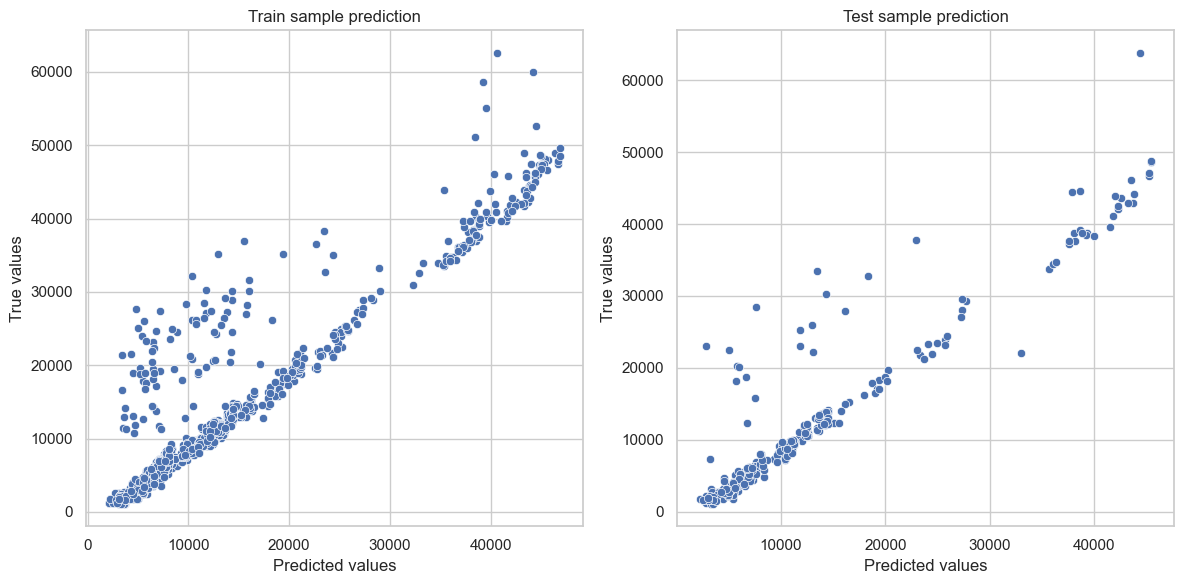

In [182]:
# Обучаем модель с лучшими параметрами
best_gbr = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=2,
    min_samples_split=4,
    n_estimators=54,
    subsample=0.8,
    random_state=42
)

best_gbr.fit(X_train, y_train)

# Предсказания
y_train_pred_best = best_gbr.predict(X_train)
y_test_pred_best = best_gbr.predict(X_test)

# Оценка качества
evaluate_preds(y_train, y_train_pred_best, y_test, y_test_pred_best)


### Выводы по оптимизации модели

- До подбора гиперпараметров градиентный бустинг показал хорошие результаты на тестовой выборке:  
  **Test R² = 0.88**, **MAE ≈ 2476**, **RMSE ≈ 4363**.
  
- После подбора параметров с помощью RandomizedSearchCV:
  - **Test R²** практически не изменился (**0.878**).
  - **MAE** слегка увеличился (**с 2476 до 2491**).
  - **RMSE** немного улучшился (**с 4363 до 4345**).

- В целом качество модели осталось стабильным:  
  улучшение RMSE свидетельствует о небольшом снижении крупных ошибок,  
  а рост MAE указывает на небольшое увеличение средних ошибок.

> Таким образом, подбор гиперпараметров подтвердил, что базовая модель уже была хорошо настроена, а оптимизация позволила добиться чуть более стабильных результатов без ухудшения общей производительности.


# 9. Финальные выводы и рекомендации

---

## Выводы проекта

В ходе проекта:

- Мы изучили и проанализировали данные о клиентах страховой компании.
- Сформулировали и проверили статистическую гипотезу:
  - Курение статистически значительно увеличивает стоимость медицинской страховки.
- Построили две модели прогнозирования расходов:
  - Линейную регрессию.
  - Градиентный бустинг.
- Провели подбор гиперпараметров для градиентного бустинга.
- Достигли высокого качества предсказаний:
  - **Test R² ≈ 0.878**, что означает, что почти 88% вариации расходов объясняется моделью.
  - Средняя ошибка модели составляет около **2491 у.е.**.

## Бизнес-рекомендации

- **Фактор курения** — один из наиболее значимых драйверов увеличения расходов. Рекомендуется учитывать его в тарифной политике страховой компании.
- **Индекс массы тела (BMI)** также влияет на стоимость страховки, особенно в категориях ожирения. Возможна разработка продуктов, учитывающих уровень здоровья клиентов.
- Разработанная модель может быть использована для **предварительной оценки** расходов при расчёте страховых тарифов для новых клиентов.

> При использовании модели в реальной практике рекомендуется дополнительно учесть обновления данных и регулярно переобучать модель на новых данных для поддержания её актуальности.

---

Проект считаю успешно завершённым.